In [1]:
sentences = ["我 喜欢 玩具",
             "我 爱 爸爸",
             "我 讨厌 挨打"]

words_list = list(set(" ".join(sentences).split()))
word_to_idx = {word: idx for idx, word in enumerate(words_list)}
idx_to_word = {idx: word for idx, word in enumerate(words_list)}
voc_size = len(words_list)
print("词汇表：", words_list)
print("词汇到索引的字典", word_to_idx)
print("索引到词汇的字典", idx_to_word)
print("词汇表大小：", voc_size)


词汇表： ['玩具', '爸爸', '讨厌', '挨打', '我', '爱', '喜欢']
词汇到索引的字典 {'玩具': 0, '爸爸': 1, '讨厌': 2, '挨打': 3, '我': 4, '爱': 5, '喜欢': 6}
索引到词汇的字典 {0: '玩具', 1: '爸爸', 2: '讨厌', 3: '挨打', 4: '我', 5: '爱', 6: '喜欢'}
词汇表大小： 7


In [2]:
import torch
import random
batch_size = 2
def make_batch():
    input_batch = []
    target_batch = []
    selected_sentences = random.sample(sentences, batch_size)
    for sentence in selected_sentences:
        words = sentence.split()
        input_data = [word_to_idx[word] for word in words[:-1]]
        target = word_to_idx[words[-1]]
        input_batch.append(input_data)
        target_batch.append(target)
    return torch.LongTensor(input_batch), torch.LongTensor(target_batch)

input_batch, target_batch = make_batch()
print("input_batch:", input_batch)
print("target_batch:", target_batch)
input_words = []
for input_idx in input_batch:
    input_words.append(idx_to_word[idx.item()] for idx in input_idx)
print("input_words:", input_words)
print("target_batch:", target_batch)
target_words = [idx_to_word[idx.item()] for idx in target_batch]
print("target_words:", target_words)

input_batch: tensor([[4, 2],
        [4, 6]])
target_batch: tensor([3, 0])
input_words: [<generator object <genexpr> at 0x000001393221C040>, <generator object <genexpr> at 0x000001393234B370>]
target_batch: tensor([3, 0])
target_words: ['挨打', '玩具']


In [3]:
import torch.nn as nn
class NPLM(nn.Module):
    def __init__(self, embedding_size, n_hidden):
        super(NPLM, self).__init__()
        self.C = nn.Embedding(voc_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, n_hidden, batch_first=True)
        self.linear2 = nn.Linear(n_hidden, voc_size)
        self.embedding_size = embedding_size
    def forward(self, x):
        x = self.C(x) # [batch_size, n_step, embedding_size]
        lstm_out, _ = self.lstm(x) #[batch_size, n_step, n_hidden]
        output = self.linear2(lstm_out[:, -1, :])
        return output
    
model = NPLM(2, 2)
print(model)

NPLM(
  (C): Embedding(7, 2)
  (lstm): LSTM(2, 2, batch_first=True)
  (linear2): Linear(in_features=2, out_features=7, bias=True)
)


Epoch: 0100 cost = 1.363663
Epoch: 0200 cost = 1.283936
Epoch: 0300 cost = 1.471921
Epoch: 0400 cost = 1.239972
Epoch: 0500 cost = 1.073280
Epoch: 0600 cost = 0.925043
Epoch: 0700 cost = 0.835084
Epoch: 0800 cost = 0.655810
Epoch: 0900 cost = 0.623973
Epoch: 1000 cost = 0.771562
Epoch: 1100 cost = 0.565291
Epoch: 1200 cost = 0.539297
Epoch: 1300 cost = 0.652523
Epoch: 1400 cost = 0.405914
Epoch: 1500 cost = 0.454575
Epoch: 1600 cost = 0.329054
Epoch: 1700 cost = 0.386473
Epoch: 1800 cost = 0.268632
Epoch: 1900 cost = 0.373669
Epoch: 2000 cost = 0.209972
Epoch: 2100 cost = 0.287100
Epoch: 2200 cost = 0.223142
Epoch: 2300 cost = 0.155192
Epoch: 2400 cost = 0.190181
Epoch: 2500 cost = 0.168916
Epoch: 2600 cost = 0.116808
Epoch: 2700 cost = 0.106916
Epoch: 2800 cost = 0.116339
Epoch: 2900 cost = 0.090637
Epoch: 3000 cost = 0.102038
Epoch: 3100 cost = 0.094182
Epoch: 3200 cost = 0.087145
Epoch: 3300 cost = 0.081268
Epoch: 3400 cost = 0.062399
Epoch: 3500 cost = 0.068544
Epoch: 3600 cost = 0

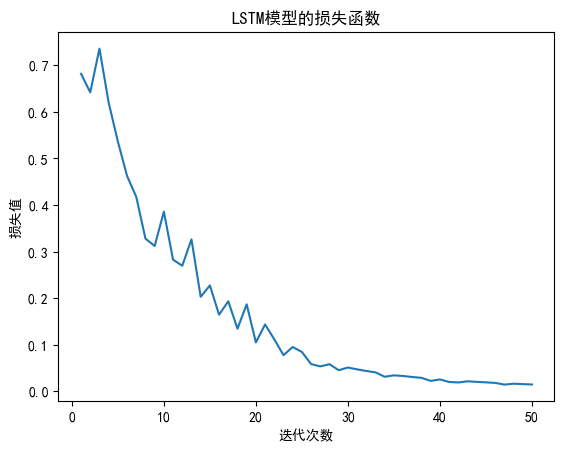

In [4]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
for epoch in range(5000):
    input_batch, target_batch = make_batch()
    optimizer.zero_grad()
    output = model(input_batch)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 100 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "cost =", "{:.6f}".format(loss.item()))
        losses.append(loss.item()/batch_size)
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(1, 5000//100 + 1), losses)
plt.title('LSTM模型的损失函数')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()

In [5]:
input_strs = [['我', '讨厌'],['我', '喜欢']]
input_indices = [[word_to_idx[word] for word in input_str] for input_str in input_strs]
input_batch = torch.LongTensor(input_indices)
predict = model(input_batch)
predict = predict.data.max(1, keepdim=True)[1]
print("input_strs:", input_strs)
print("predict:", predict)
predict_words = []
for idx in predict:
    predict_words.append(idx_to_word[idx.item()])
print("predict_words:", predict_words)

input_strs: [['我', '讨厌'], ['我', '喜欢']]
predict: tensor([[3],
        [0]])
predict_words: ['挨打', '玩具']
